In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import os
from graphviz import Source
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/release/bin' #Esta línea es necesaria para que graphviz funcione en windows
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import imblearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

#### Se procede a probar los modelos elegidos anteriormente, usando la matriz de confusiòn y las curvas ROG

In [2]:
## Cargado del dataset original
data = pd.read_csv("C:/Users/pjlu_/Desktop/DataminingUPB.csv", sep=";")
data.rename(columns={'Humedad en aire':'hum_aire',
                          'Humedad en suelo 1':'hum_gnd_1',
                          'Humedad en suelo 2':'hum_gnd_2',
                          'Unnamed: 2':'unidad',
                    'Unnamed: 4':'unidad_3',
                    'Unnamed: 6':'unidad_5',
                    'Unnamed: 8':'unidad_7',
                    'Unnamed: 10':'unidad_9',
                    'Unnamed: 12':'unidad_11'},
                 inplace=True)

## Borrado de columna de unidades
data = data.drop(["unidad","unidad_3","unidad_5","unidad_7","unidad_9","unidad_11"],axis =1)

##Separado de los datos correspondientes al sujeto 1
data2 = data.drop(["EstadosPlanta_2","N_hojas_2","hum_gnd_2",],axis =1)

##Separado de los datos correspondientes al sujeto 2
data3 = data.drop(["EstadosPlanta_1","N_hojas_1","hum_gnd_1"],axis =1)

## Homogeneizado en encabezados de la tabla de datos de sujeto 1 y agregado de columna para la identificaciòn de estos
data2.rename(columns={'hum_gnd_1':'hum_gnd','EstadosPlanta_1':'EstadosPlanta','N_hojas_1':'N_hojas'},inplace=True)
data2['sujeto']= "1"

## Homogeneizado en encabezados de la tabla de datos de sujeto 2 y agregado de columna para la identificaciòn de estos
data3.rename(columns = {'hum_gnd_2':'hum_gnd','EstadosPlanta_2':'EstadosPlanta','N_hojas_2':'N_hojas'},inplace=True)
data3['sujeto'] = "2"

##Unión de los datos de sujetos 1 y 2 en un nuevo dataset
data4 = pd.concat([data2,data3])

## Eliminado de filas donde falte al menos un dato
data4 = data4.dropna(axis=0, how="any")

## Eliminado de la columna fecha
data_nfecha = data4.drop(["Time"],axis = 1)

In [3]:
data_nfecha.tail()

,Temperatura,CO2,hum_aire,hum_gnd,Luminosidad,EstadosPlanta,N_hojas,sujeto
10364,2569,6272,703,50721.0,16377,2.0,43.0,2
10365,2576,6388,700,50719.0,16382,2.0,43.0,2
10366,2576,6489,696,50721.0,16386,2.0,43.0,2
10367,2574,6462,700,50720.0,16385,2.0,43.0,2
10368,2553,6284,697,50719.0,16391,3.0,0.0,2


## Árbol de decisiòn

In [4]:
colnames = data_nfecha.columns.values.tolist()
predictores = colnames
target = colnames[5]
predictores.remove('EstadosPlanta')

In [5]:
## Divisiòn de la data en datos de entrenamiento y test

#Creaciòn de columna Training, donde el 75% seràn True y el 25% False (75 % pertenecen a los datos de entrenamiento y 25% a test) 
data_nfecha["Training"] = np.random.uniform(0,1, len(data_nfecha))<=0.75 

## Separaciòn de los datos de entrenamiento y test
train, test = data_nfecha[data_nfecha["Training"]==True], data_nfecha[data_nfecha["Training"]==False]

In [6]:
## Creaciòn del árbol de decisiòn
X_train = train[predictores]
Y_train = train[target]

X_test = test[predictores]
Y_test = test[target]

arbol = DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_split=20, random_state=99)
##arbol.fit(X,Y)

In [7]:
## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_train.shape[0], shuffle=True, random_state=1)
scores=cross_val_score(arbol, X_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds=cross_val_predict(arbol, X_train, Y_train, cv = 10, n_jobs=-1)

In [8]:
preds

array([2., 2., 2., ..., 2., 2., 2.])

In [9]:
print(scores)

[0.54838522 1.         0.64027904 0.89567806 1.         1.
 0.79379189 0.89172441 0.61273236 0.94081175]


(array([9153.,    0.,    0.,    0.,    0., 2702.,    0.,    0.,    0.,
         212.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

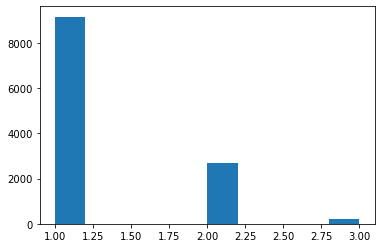

In [10]:
plt.hist(preds)

## Matriz de confusón


In [11]:
pd.crosstab(Y_train,preds, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0,3.0
Real,,,
1.0,8661,1458,0
2.0,492,1243,0
3.0,0,1,212


In [12]:
target_names = ['1', '2', '3']
print(classification_report(Y_train, preds, target_names=target_names))

              precision    recall  f1-score   support

           1       0.95      0.86      0.90     10119
           2       0.46      0.72      0.56      1735
           3       1.00      1.00      1.00       213

    accuracy                           0.84     12067
   macro avg       0.80      0.86      0.82     12067
weighted avg       0.88      0.84      0.85     12067



<AxesSubplot:>

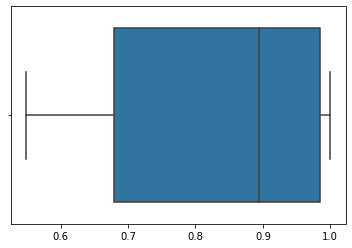

In [13]:
sns.boxplot(scores)

## Random Forest

In [14]:
forest = RandomForestClassifier(n_jobs=-1, oob_score=True,n_estimators=500,criterion="entropy", max_depth=4, min_samples_split=20, random_state=99)
##forest.fit(X,Y)

In [15]:
## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_train.shape[0], shuffle=True, random_state=1)
scores_forest=cross_val_score(forest, X_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds_forest=cross_val_predict(forest, X_train, Y_train, cv = 10, n_jobs=-1)

In [16]:
print(scores_forest)

[0.64027904 0.68067678 0.64027904 0.8864694  0.78187119 0.69229902
 0.73787486 0.87796051 0.57220829 0.89995647]


(array([10848.,     0.,     0.,     0.,     0.,   969.,     0.,     0.,
            0.,   250.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

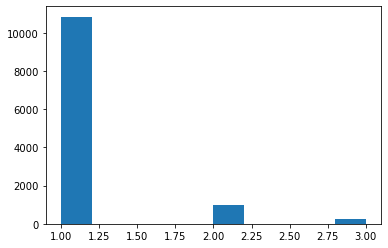

In [17]:
plt.hist(preds_forest)

In [18]:
pd.crosstab(Y_train,preds_forest, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0,3.0
Real,,,
1.0,9639,480,0
2.0,1209,487,39
3.0,0,2,211


In [19]:
target_names = ['1', '2', '3']
print(classification_report(Y_train, preds_forest, target_names=target_names))

              precision    recall  f1-score   support

           1       0.89      0.95      0.92     10119
           2       0.50      0.28      0.36      1735
           3       0.84      0.99      0.91       213

    accuracy                           0.86     12067
   macro avg       0.75      0.74      0.73     12067
weighted avg       0.83      0.86      0.84     12067



<AxesSubplot:>

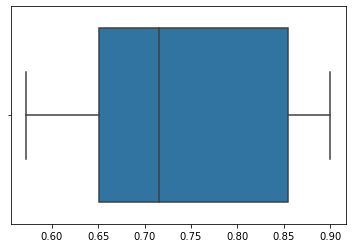

In [20]:
sns.boxplot(scores_forest)

## Random Forest con opción de data balanceada

In [21]:
forest2 = RandomForestClassifier(n_jobs=-1, oob_score=True,n_estimators=500,criterion="entropy",class_weight='balanced', max_depth=4, min_samples_split=20, random_state=99)


In [22]:
## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_train.shape[0], shuffle=True, random_state=1)
scores_forest2=cross_val_score(forest2, X_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds_forest2=cross_val_predict(forest2, X_train, Y_train, cv = 10, n_jobs=-1)

In [23]:
print(scores_forest2)

[0.93410612 1.         1.         0.96239696 0.94946936 0.98683874
 0.76745839 0.41826215 0.59983659 0.6230784 ]


(array([7617.,    0.,    0.,    0.,    0., 4237.,    0.,    0.,    0.,
         213.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

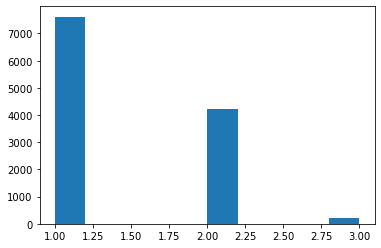

In [24]:
plt.hist(preds_forest2)

In [25]:
pd.crosstab(Y_train,preds_forest2, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0,3.0
Real,,,
1.0,7484,2635,0
2.0,133,1602,0
3.0,0,0,213


In [26]:
target_names = ['1', '2', '3']
print(classification_report(Y_train, preds_forest2, target_names=target_names))

              precision    recall  f1-score   support

           1       0.98      0.74      0.84     10119
           2       0.38      0.92      0.54      1735
           3       1.00      1.00      1.00       213

    accuracy                           0.77     12067
   macro avg       0.79      0.89      0.79     12067
weighted avg       0.90      0.77      0.80     12067



<AxesSubplot:>

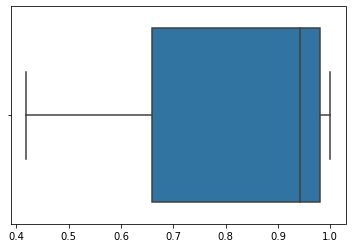

In [27]:
sns.boxplot(scores_forest2)

## Datos Normalizados

In [28]:
X_norm_train = StandardScaler().fit_transform(X_train)
X_norm_test = StandardScaler().fit_transform(X_test)

X_norm_train

array([[-0.3422423 , -0.19796387, -0.36115062, ..., -0.66432286,
        -0.44228476, -0.84992989],
       [-0.3422423 ,  1.36066221, -0.37783833, ..., -0.66432286,
        -0.44228476, -0.84992989],
       [-0.41842077, -0.19796387, -0.45293304, ..., -0.6568075 ,
        -0.44228476, -0.84992989],
       ...,
       [-0.52845633, -0.19796387, -0.36115062, ..., -0.67100319,
        -2.16823355,  1.17656764],
       [-0.52845633,  1.02235577, -0.39452604, ..., -0.66766303,
        -2.16823355,  1.17656764],
       [-0.54538488,  0.69613171, -0.36115062, ..., -0.66849807,
        -2.16823355,  1.17656764]])

## Arbol de decisòn normalizado

In [29]:
arbol_norm = DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_split=20, random_state=99)

## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_norm_train.shape[0], shuffle=True, random_state=1)
scores_norm=cross_val_score(arbol_norm, X_norm_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds_norm=cross_val_predict(arbol_norm, X_norm_train, Y_train, cv = 10, n_jobs=-1)

(array([9153.,    0.,    0.,    0.,    0., 2702.,    0.,    0.,    0.,
         212.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

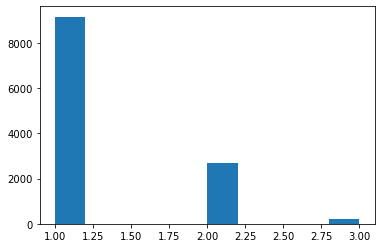

In [30]:
plt.hist(preds_norm)

## Matriz de confusiòn para datos normalizados - Arbol de decisión

In [31]:
pd.crosstab(Y_train,preds_norm, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0,3.0
Real,,,
1.0,8661,1458,0
2.0,492,1243,0
3.0,0,1,212


In [32]:
target_names = ['1', '2', '3']
print(classification_report(Y_train, preds_norm, target_names=target_names))

              precision    recall  f1-score   support

           1       0.95      0.86      0.90     10119
           2       0.46      0.72      0.56      1735
           3       1.00      1.00      1.00       213

    accuracy                           0.84     12067
   macro avg       0.80      0.86      0.82     12067
weighted avg       0.88      0.84      0.85     12067



<AxesSubplot:>

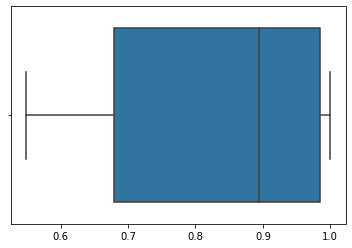

In [33]:
sns.boxplot(scores_norm)

## Random Forest normalizado

In [34]:
forest_norm = RandomForestClassifier(n_jobs=-1, oob_score=True,n_estimators=500,criterion="entropy",class_weight='balanced', max_depth=4, min_samples_split=20, random_state=99)

## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_norm_train.shape[0], shuffle=True, random_state=1)
scores_forest_norm=cross_val_score(forest_norm, X_norm_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds_forest_norm=cross_val_predict(forest_norm, X_norm_train, Y_train, cv = 10, n_jobs=-1)

(array([7643.,    0.,    0.,    0.,    0., 4211.,    0.,    0.,    0.,
         213.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

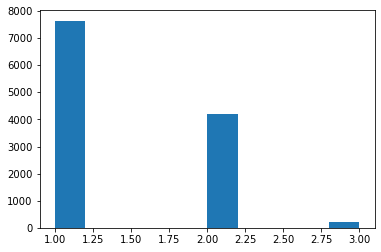

In [35]:
plt.hist(preds_forest_norm)

## Matriz de confusiòn para datos normalizados - Random Forest

In [36]:
pd.crosstab(Y_train,preds_forest_norm, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0,3.0
Real,,,
1.0,7484,2635,0
2.0,159,1576,0
3.0,0,0,213


In [37]:
target_names = ['1', '2', '3']
print(classification_report(Y_train, preds_forest_norm, target_names=target_names))

              precision    recall  f1-score   support

           1       0.98      0.74      0.84     10119
           2       0.37      0.91      0.53      1735
           3       1.00      1.00      1.00       213

    accuracy                           0.77     12067
   macro avg       0.78      0.88      0.79     12067
weighted avg       0.89      0.77      0.80     12067



<AxesSubplot:>

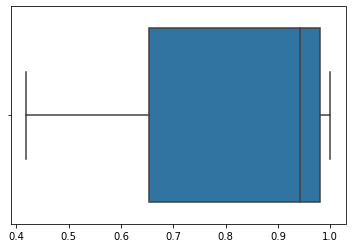

In [38]:
sns.boxplot(scores_forest_norm)

## Analisis de componentes principales

In [39]:
pca = PCA()
pca.fit(X_norm_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) +1

In [40]:
pca.explained_variance_ratio_

array([0.27972031, 0.19219332, 0.17029027, 0.14276897, 0.11516858,
       0.0815191 , 0.01833944])

In [41]:
X_norm.shape

NameError: name 'X_norm' is not defined

In [ ]:
X.columns